In [2]:
import time
import itertools
import numpy as np
import pandas as pd
import os, math, pylab, random 
import matplotlib.pyplot as plt

# Hard Disks Colisions

The predictions of the next colisions

$r(t) = r_0(t_0) + v (t-t_0)$ logo $t-t_0 = del_t = (r(t) - r_0(t_0) ) / v$

The "wall_time" calcule the time of the next colision between the disk and the wall and "pair_time" betweem themself. thus, we need see which one happens first.

In [3]:
def wall_time(pos_a, vel_a, radius):
    if vel_a > 0.0: #Hit the up or right wall
        del_t = (1.0 - radius - pos_a) / vel_a #Time for next colision
    elif vel_a < 0.0: #Hit the botton or left wall
        del_t = (pos_a - radius) / abs(vel_a) #Time for next colision
    else:
        del_t = float('inf') #infinity
    return del_t

def pair_time(pos_a, vel_a, pos_b, vel_b, radius):
    del_x    = [pos_b[0] - pos_a[0] , pos_b[1] - pos_a[1]]                #distance in x and y
    del_x_sq =  del_x[0] ** 2 + del_x[1] ** 2                             #distance module 
    del_v    = [vel_b[0] - vel_a[0] , vel_b[1] - vel_a[1]]                #velocity sum   
    del_v_sq =  del_v[0] ** 2 + del_v[1] ** 2                             #velocity mudule
    scal     =  del_v[0] * del_x[0] + del_v[1] * del_x[1]
    Upsilon  =  scal ** 2 - del_v_sq * ( del_x_sq - 4.0 * radius **2)
    if Upsilon > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(Upsilon)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t

The "inition_condition" create N disks and test the overlap.

In [4]:
def inition_condition(N, radius):
    pairs = [(i, j) for i in range(N - 1) for j in range(i + 1, N)]
    velocity = np.random.uniform(-1,1,size=(N,2))
    
    while True:
        P = [(random.uniform(radius, 1.0 - radius), random.uniform(radius, 1.0 - radius)) for k in range(N)]
        if  min(  (P[i][0] - P[j][0]) ** 2 + (P[i][1] - P[j][1]) ** 2 for i, j in pairs ) > 4.0 * radius ** 2: 
            break
    return np.array(P), velocity
inition_condition(4, .1)

(array([[0.41375524, 0.1565543 ],
        [0.32679012, 0.62470589],
        [0.88720867, 0.48796665],
        [0.52586969, 0.87628846]]), array([[ 0.66746772,  0.94250941],
        [ 0.20879327,  0.03313216],
        [ 0.98741551, -0.72124215],
        [-0.30244288, -0.372248  ]]))

In [5]:
sigma = 0.15
P = [(random.uniform(sigma, 1.0 - sigma), random.uniform(sigma, 1.0 - sigma)) for k in range(4)]
P

[(0.5307147164019221, 0.3122997025611081),
 (0.3285415005863007, 0.603854839656712),
 (0.17121454485450024, 0.38504988517851396),
 (0.3336822954280174, 0.5974982197014573)]

## The Plot

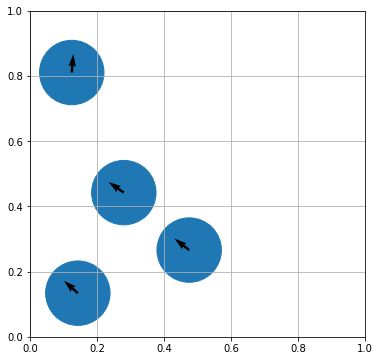

In [6]:
AV = inition_condition(4, .1)
A,V = AV[0], AV[1]
s = [4150 for n in range(4)]
plt.figure(figsize=(6,6))
plt.scatter(A[:,0],A[:,1],s=s)
for i in range(len(V)):
    origin = A[i] # origin point
    plt.quiver(*origin, V[i,0], V[i,1])
plt.xlim(0, 1) 
plt.ylim(top=1) 
plt.ylim(bottom=0)
plt.grid()
plt.show()

## The Colisions

Here, in single_pairs, we have the conditions that we need to use to test the colisions time

In [10]:
def single_pairs(n):
    singles   = np.array([(i, j) for i in range(n) for j in range(2)])
    pairs     = np.array([(i, j) for i in range(n - 1) for j in range(i + 1, n)])
    
    return singles, pairs
single_pairs(4)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1],
        [2, 0],
        [2, 1],
        [3, 0],
        [3, 1]]), array([[0, 1],
        [0, 2],
        [0, 3],
        [1, 2],
        [1, 3],
        [2, 3]]))

In [11]:
def hard_disk_N_colision(n, events, sigma=0.10):
    PV = inition_condition(n, sigma) 
    pos , vel = PV[0], PV[1]
    singles, pairs   = single_pairs(n)[0], single_pairs(n)[1] #Construir essas funções
    
    data = np.concatenate((pos, vel), axis=1)
    df = pd.DataFrame(data)
    
    t = 0
    
    for event in range(events):
        wall_times = [wall_time(pos[k,l], vel[k,l], sigma)             for k, l in singles]
        pair_times = [pair_time(pos[k], vel[k], pos[l], vel[l], sigma) for k, l in pairs]
        next_event = min(wall_times + pair_times)
        t += next_event
    
        for k, l in singles: pos[k][l] += vel[k][l] * next_event 
        
        if min(wall_times) < min(pair_times):
            collision_disk, direction = singles[wall_times.index(next_event)]
            vel[collision_disk][direction] *= -1.0
        else: 
            a, b = pairs[pair_times.index(next_event)]
            del_x = [pos[b][0] - pos[a][0], pos[b][1] - pos[a][1]]
            abs_x = math.sqrt(del_x[0] ** 2 + del_x[1] ** 2)
            e_perp = [c / abs_x for c in del_x]
            del_v = [vel[b][0] - vel[a][0], vel[b][1] - vel[a][1]]
            scal = del_v[0] * e_perp[0] + del_v[1] * e_perp[1]
            for k in range(2): 
                vel[a][k] += e_perp[k] * scal 
                vel[b][k] -= e_perp[k] * scal
        
        DF = np.concatenate( (pos, vel), axis=1)
        df = pd.concat([df, pd.DataFrame(DF)], axis=0)
    
    return df

In [23]:
DF = hard_disk_N_colision(n=4, events=3, sigma=0.10)
df0 = DF[0:4]
df1 = DF[8:12]

In [24]:
x0, y0, vx0, vy0 = df0[0], df0[1], df0[2], df0[3]
x1, y1, vx1, vy1 = df1[0], df1[1], df1[2], df1[3]

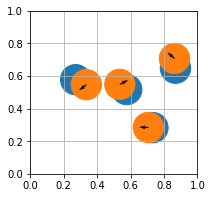

In [25]:
s = [920 for n in range(4)]
plt.figure(figsize=(3,3))
plt.scatter(x0,y0,s=s)
for i in range(len(V)):
    origin = x0[i],y0[i] # origin point
    plt.quiver(*origin, vx0[i], vy0[i])
plt.scatter(x1,y1,s=s)
for i in range(len(V)):
    origin = x1[i],y1[i] # origin point
    plt.quiver(*origin, vx1[i], vy1[i])
plt.xlim(0, 1) 
plt.ylim(top=1) 
plt.ylim(bottom=0)
plt.grid()
plt.show()

array([ 0.35114648,  0.24256356,  0.03277608, -0.15901048])